In [1]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE
import seaborn as sns
from typing import Literal

In [2]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i + 1], t2s[met_i - 1:met_i + 1], M_0s[met_i - 1:met_i + 1]
spins_phi = np.zeros_like(M_0s)
ws[0] = ws[1]
t2s[0] = t2s[1]
M_0s[0] = M_0s[1]

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [3]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

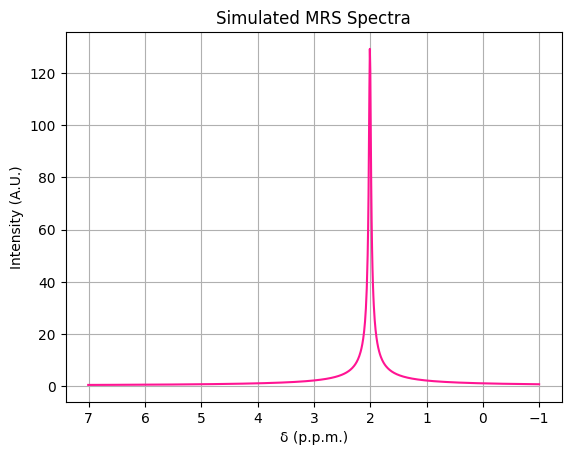

In [4]:
pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [5]:
L = 0.4
noise_threshold = 30
rcond=1e-30
L_ = int(L*sig.size)

In [6]:
size = 20
# offsets = 10**(-(np.linspace(-3, size - 3 - 1, size)))
offsets = np.array([100.0, 10.0, 7.5, 5.0, 2.5, 1.0, 0.75, 0.5, 0.25, 0.1])
print(offsets)

offset = 10.0

sample_snrs = np.array([0.25, 0.50, 0.75, 1.0, 2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0])


[100.    10.     7.5    5.     2.5    1.     0.75   0.5    0.25   0.1 ]


In [7]:
L_ = int(L*2048)
shape = (sample_snrs.size, offsets.size, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)
original_c_sigs = np.zeros((sample_snrs.size, offsets.size, 2048), dtype=np.complex128)

In [8]:
rerun = False
filename_end = "_offsets"
folder_name = "files/"
subfolder_name = "two_peaks_noisy/"

In [9]:
if rerun == True:
    for j in range(offsets.size):
        for i in range(sample_snrs.size):
            ws[1] = ws[0] + offsets[j]
            pop = pymri.population(ws, t2s, M_0s, spins_phi)

            sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
            freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
            sig_fft = sig_fft/np.nanmax(sig_fft)

            c_sig_fft = awgn(sig_fft, sample_snrs[i])
            original_c_sigs[i, j, :] = np.fft.ifft(np.fft.ifftshift(c_sig_fft))
            # pymri.plot_chem_shifts(freqs, c_sig_fft, 1.0)
            # plt.show()

            f_sig, z, r = pymri.filter_sig(original_c_sigs[i, j, :], L, noise_threshold, 
                                        return_poles_and_res=True, 
                                        return_full_arrays=True, 
                                        rcond=rcond, 
                                        zero_filtering=rcond)
            s0s_[i, j, :], phis_[i, j, :], omegas_[i, j, :], t2s_[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[i, j, :] = 1/t2s_[i, j, :]

In [10]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)
    np.save(folder_name + subfolder_name + "original_c_sigs" + filename_end, original_c_sigs)

In [11]:
if rerun == False:
    s0s_            = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_           = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_         = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_            = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")
    original_c_sigs = np.load(folder_name + subfolder_name + "original_c_sigs" + filename_end + ".npy")


In [12]:
print(s0s_.shape)

(11, 10, 819)


In [13]:
args = np.argsort(s0s_, axis=2)
print(args.shape)

(11, 10, 819)


In [20]:
i = 7
j = 9

# print(s0s_[i, args[i, :]])


identified_s0 = s0s_[i, j, args[i, j, :]]
identified_omega = omegas_[i, j, args[i, j, :]]
identified_phi = phis_[i, j, args[i, j, :]]
identified_t2 = t2s_[i, j, args[i, j, :]]


print("Original")
print(np.array([ws[0], ws[0] + offsets[j]]))
# print(np.sort(pymri.chem_shift_from_f(np.array(pymri.rad_to_hz(np.array([ws[0], ws[0] + offsets[j]]))), B0)))
print("Identificado")
# print(pymri.chem_shift_from_f(pymri.rad_to_hz(identified_omega[L_ - 2: L_]), B0))
print(identified_omega[L_ - 2: L_])
print(identified_s0[L_ - 2 : L_])
print(np.log10(identified_t2[L_ - 2 : L_]))

# print(identified_t2)
print(offsets[j])
print(sample_snrs[i])

Original
[2411.71251655 2411.81251655]
Identificado
[3115.30415954 2411.83027697]
[0.00233126 0.00665454]
[-3.29118606 -1.13563059]
0.1
25.0


Abaixo, selecionou-se a última maior amplitude como filtro, e verificou-se a evolução de seu valor, de seu t2, fase e frequência:

[ 9.19075288 -0.44532279 14.51923876  7.08713256 14.05594524  3.91114297
 13.22668803  2.12946854  2.12957098  2.12960017  2.12960026]
[False  True False False False  True False  True  True  True  True]


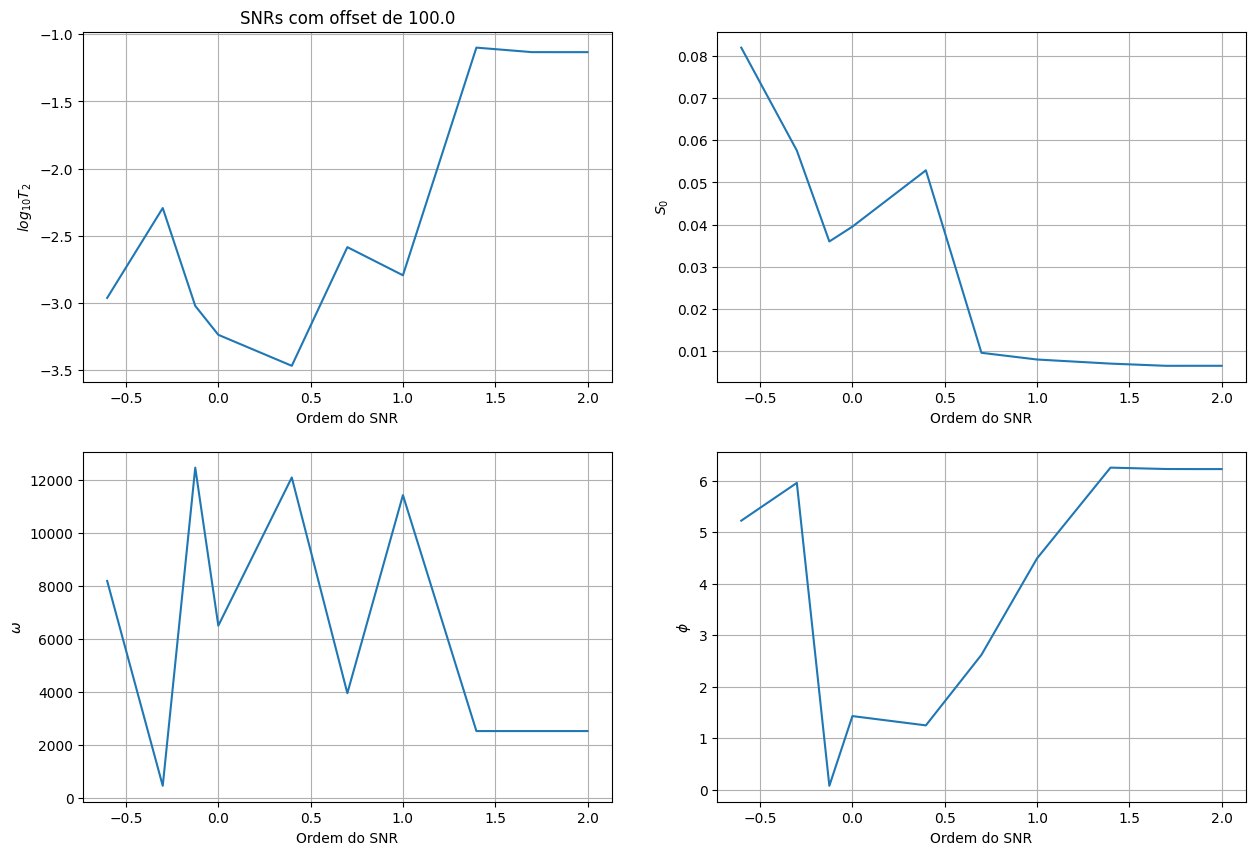

In [21]:
j_ = 0

t2_arr = np.array([t2s_[l, j_, args[l, j_, :]][-1] for l in range(sample_snrs.size)])
log10t2_arr = np.array([np.log10(t2s_[l, j_, args[l, j_, :]][-1]) for l in range(sample_snrs.size)])
s0_arr = np.array([s0s_[l, j_, args[l, j_, :]][-1] for l in range(sample_snrs.size)])
omega_arr = np.array([omegas_[l, j_, args[l, j_, :]][-1] for l in range(sample_snrs.size)])
phis_arr = np.array([phis_[l, j_, args[l, j_, :]][-1] for l in range(sample_snrs.size)])

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(np.log10(sample_snrs), log10t2_arr)
plt.ylabel(r"$log_{10} T_2$")
plt.xlabel("Ordem do SNR")
plt.title(f"SNRs com offset de {offsets[j_]}")
plt.grid()
plt.subplot(222)
plt.plot(np.log10(sample_snrs), s0_arr)
plt.ylabel(r"$S_0$")
plt.xlabel("Ordem do SNR")
plt.grid()
plt.subplot(223)
plt.plot(np.log10(sample_snrs), omega_arr)
plt.ylabel(r"$\omega$")
plt.xlabel("Ordem do SNR")
plt.grid()
plt.subplot(224)
plt.plot(np.log10(sample_snrs), phis_arr)
plt.ylabel(r"$\phi$")
plt.xlabel("Ordem do SNR")
plt.grid()

print(pymri.chem_shift_from_f(pymri.rad_to_hz(omega_arr), B0))
true_freqs = pymri.check_frequency(omega_arr, dt, True)
false_freqs = np.bitwise_not(true_freqs)
print(true_freqs)

1024.0


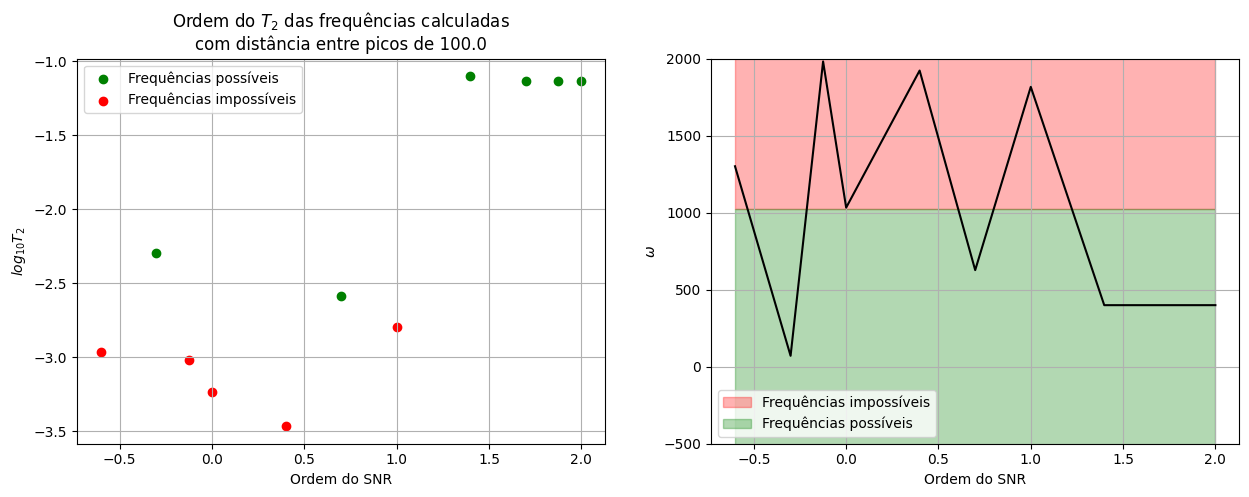

In [22]:

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(np.log10(sample_snrs[true_freqs]), log10t2_arr[true_freqs], c = "green", label = "Frequências possíveis")
plt.scatter(np.log10(sample_snrs[false_freqs]), log10t2_arr[false_freqs], c = "red", label = "Frequências impossíveis")
plt.ylabel(r"$log_{10} T_2$")
plt.xlabel("Ordem do SNR")
plt.title(r"Ordem do $T_2$ das frequências calculadas" + 
          "\n" + "com distância entre picos de " + f"{offsets[j_]}")
plt.legend()
plt.grid()

limit_omega = pymri.max_frequency(dt)
print(limit_omega)

plt.subplot(122)
plt.plot(np.log10(sample_snrs), pymri.rad_to_hz(omega_arr), c = "black")
plt.fill_between(np.log10(sample_snrs), limit_omega, 2*limit_omega, color = "red", alpha = 0.3, label = "Frequências impossíveis")
plt.fill_between(np.log10(sample_snrs), -limit_omega, -2*limit_omega, color = "red", alpha = 0.3)
plt.fill_between(np.log10(sample_snrs), -limit_omega, limit_omega, color = "green", alpha = 0.3, label = "Frequências possíveis")
plt.ylabel(r"$\omega$")
plt.xlabel("Ordem do SNR")
plt.ylim(-500, 2000)
plt.title("")
plt.legend()
plt.grid()

10.0


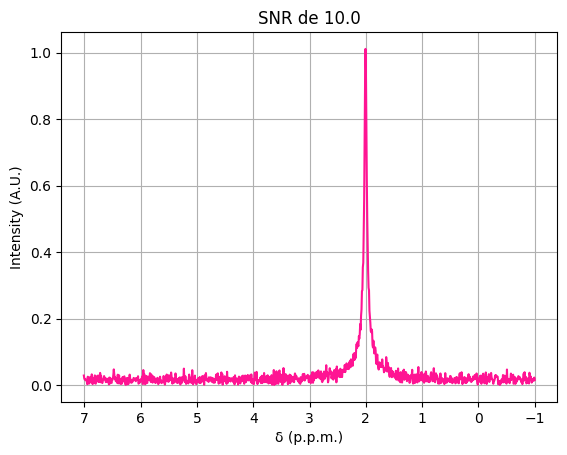

In [23]:
i_ = 6
print(sample_snrs[i_])
_, c_sig_fft = pymri.fourier_spectrum(original_c_sigs[i_, j, :], dt, B0)
pymri.plot_chem_shifts(freqs, c_sig_fft, 1.0, title = f"SNR de {sample_snrs[i_]}")

O SNR de 25 dB parece ser o limite da estabilidade do algoritmo para a identificação "correta" de um dos picos, no caso o maior.

**PRÓXIMO PASSO** : investigar se o t2 na ordem dos cálculos acima é um bom filtro.

In [24]:
identified_pop = pymri.population(identified_omega, identified_t2, identified_s0, identified_phi)

identified_sig, t = pymri.population_transverse_decay( t0, tn, dt, identified_pop)
_, identified_sig_fft = pymri.fourier_spectrum(identified_sig, dt, B0)

[2411.71251655 2411.81251655]


([], [])

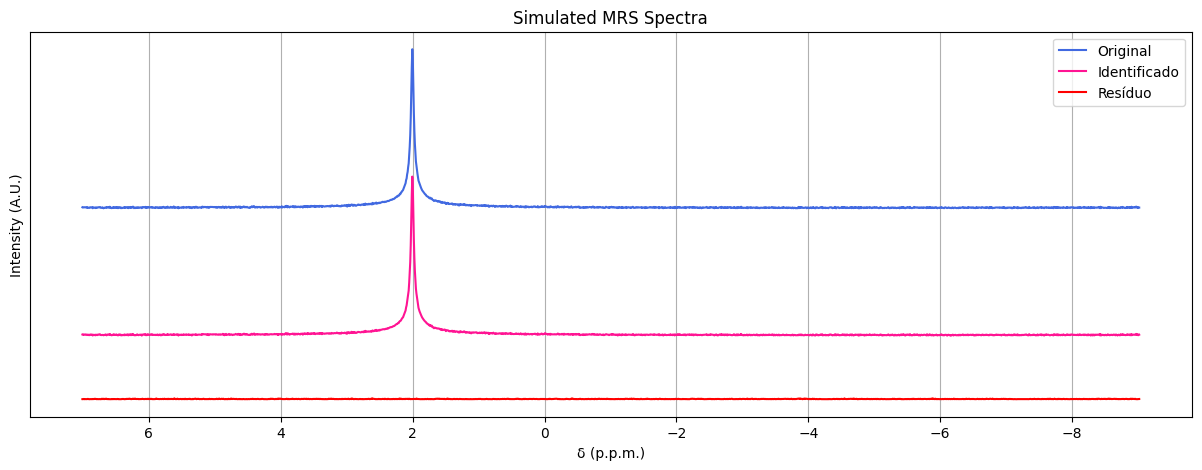

In [25]:
ws[1] = ws[0] + offsets[j]
print(ws)

_, c_sig_fft = pymri.fourier_spectrum(original_c_sigs[i, j, :], dt, B0)

y_offset = 0.8

plt.figure(figsize=(15, 5))
pymri.plot_chem_shifts(freqs, c_sig_fft, y_offset=2*y_offset, label="Original", c = "royalblue", plot_full_spectrum=True)
pymri.plot_chem_shifts(freqs, identified_sig_fft, y_offset=y_offset, label="Identificado", title=f"SNR de {sample_snrs[i]} com offset de {offsets[j]}", plot_full_spectrum=True)
pymri.plot_chem_shifts(freqs, c_sig_fft - identified_sig_fft, y_offset=0.5*y_offset, label="Resíduo", c = "red", plot_full_spectrum=True)
plt.legend()
plt.yticks([])

Pelos resultados acima, parece ser possível concluir que a amplitude sozinha deixa de ser um bom parâmetro de filtro para dois picos com um grau significativo de sobreposição. É possível perceber que para SNRs mais altos, as duas frequências com maiores amplitudes são as frequências originais, enquanto abaixo de um certo valor de SNR isso deixa de ser verdade, até chegar em um ponto na qual nenhuma das duas frequências principais aparecem com as maiores amplitudes do sinal.